In [35]:
import sys
sys.path.insert(0, '../../..')
# from Practice.Utils.metrics import evaluate_classification
# from Practice.Utils.plots import plot_decision_boundary, plot_data

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
def evaluate_classification(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    return accuracy, report, confusion

In [37]:
def plot_decision_boundary(clf, X, y):
    # Define the range of values for the features
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Use the classifier to predict the class of each point in the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and the data points
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision boundary')

In [38]:
def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [39]:
class NeuralNet:
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_1):
        W1 = np.random.randn(n_1, n_x) * 0.01
        b1 = np.zeros((n_1, 1))
        W2 = np.random.randn(1, n_1) * 0.01
        b2 = 0 # у вихідному шарі лише 1 нейрон
        self.parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
       
    def __forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        Z1 = np.dot(W1, X) + b1
        A1 = self.__sigmoid(Z1)

        Z2 = np.dot(W2, A1) + b2
        A2 = self.__sigmoid(Z2)

        
        cache = (W1, b1, W2, b2, Z1, A1, Z2, A2)

        return A2, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        
        dZ2 = A2 - Y
        dW2 = 1. / m * np.dot(dZ2, A1.T)
        db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        

        grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        return grads
    
    def __update_parameters(self, grads):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        

        self.parameters["W1"] = W1 - self.learning_rate * dW1
        self.parameters["b1"] = b1 - self.learning_rate * db1
        self.parameters["W2"] = W2 - self.learning_rate * dW2
        self.parameters["b2"] = b2 - self.learning_rate * db2

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, 20)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((1 - probs.T, probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 1]
        return (positive_probs >= 0.5).astype(int)   


# Симульовані дані 1

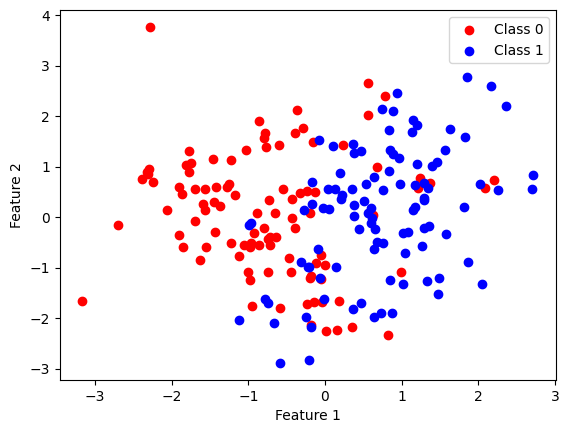

0-th iteration: 0.693164432626661
1000-th iteration: 0.6923186466847113
2000-th iteration: 0.6902910762637211
3000-th iteration: 0.6810091073684568
4000-th iteration: 0.6454772907243039
5000-th iteration: 0.5674961109236983
6000-th iteration: 0.4960703476530247
7000-th iteration: 0.46161355989096775
8000-th iteration: 0.4480066197884758
9000-th iteration: 0.44263946307036267
10000-th iteration: 0.44040144986176
11000-th iteration: 0.4393697257992581
12000-th iteration: 0.43881110975987847
13000-th iteration: 0.4384409977514973
14000-th iteration: 0.4381473166375603
15000-th iteration: 0.4378852194389824
16000-th iteration: 0.43763624042955196
17000-th iteration: 0.4373922883511301
18000-th iteration: 0.43714933056280947
19000-th iteration: 0.43690488765649454
20000-th iteration: 0.43665703384994076
21000-th iteration: 0.43640399458657664
22000-th iteration: 0.4361439821781149
23000-th iteration: 0.4358751277672556
24000-th iteration: 0.43559545434338
25000-th iteration: 0.4353028700663

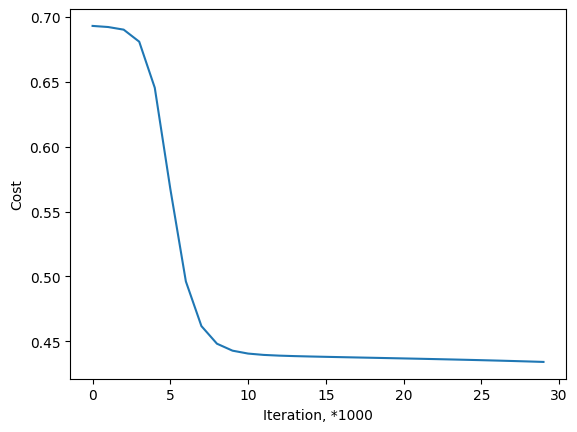

Accuracy: 
0.8
Report: 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.73      0.89      0.80        18

    accuracy                           0.80        40
   macro avg       0.81      0.81      0.80        40
weighted avg       0.82      0.80      0.80        40

Confusion: 
[[16  6]
 [ 2 16]]


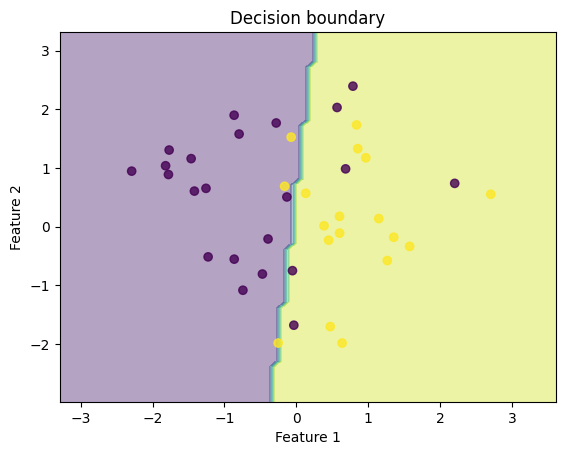

In [40]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet()
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

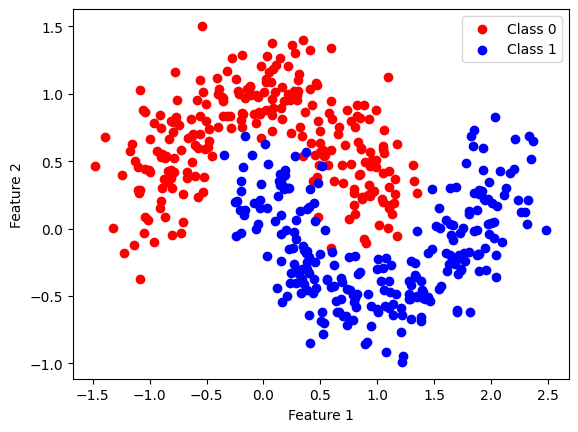

0-th iteration: 0.6932404406665487
1000-th iteration: 0.28173512452500177
2000-th iteration: 0.2810361471769153
3000-th iteration: 0.28066889646576193
4000-th iteration: 0.2804317992990105
5000-th iteration: 0.2802616174224502
6000-th iteration: 0.2801311777653717
7000-th iteration: 0.2800263073679745
8000-th iteration: 0.27993858686338985
9000-th iteration: 0.27986244438670116
10000-th iteration: 0.27979365059452316
11000-th iteration: 0.2797281636515001
12000-th iteration: 0.2796604193664651
13000-th iteration: 0.2795781179967458
14000-th iteration: 0.27943109527466675
15000-th iteration: 0.27858578927562216
16000-th iteration: 0.26314217500814463
17000-th iteration: 0.24594128040867497
18000-th iteration: 0.2396359864651675
19000-th iteration: 0.23668905909451454
20000-th iteration: 0.23493145334454546
21000-th iteration: 0.21936580884570844
22000-th iteration: 0.11954253012422189
23000-th iteration: 0.09465246612301007
24000-th iteration: 0.0848309304532817
25000-th iteration: 0.07

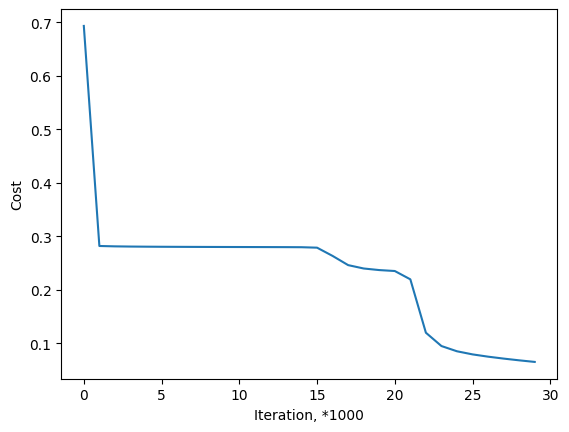

Accuracy: 
0.99
Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion: 
[[43  0]
 [ 1 56]]


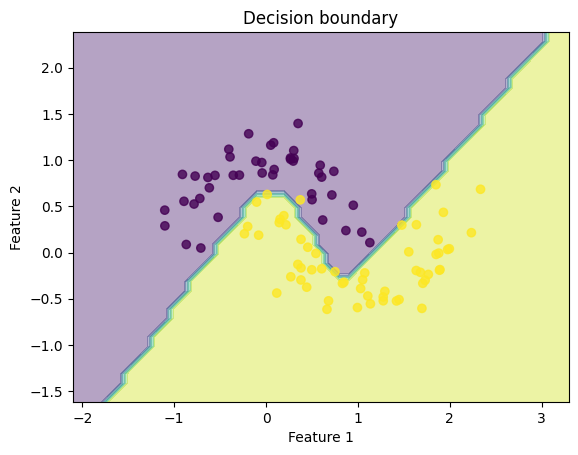

In [41]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(learning_rate = 0.5)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

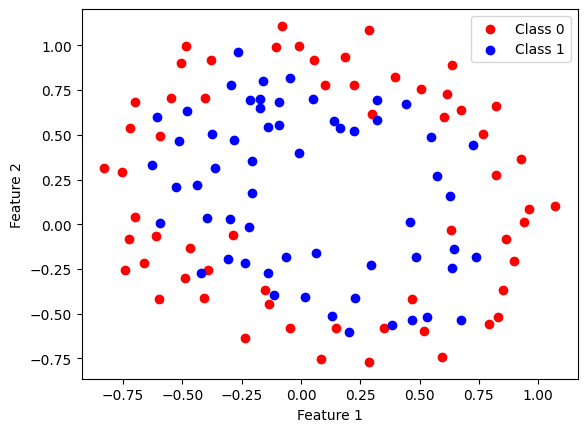

In [42]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.6930707954031159
1000-th iteration: 0.6833429477098626
2000-th iteration: 0.6391441114221628
3000-th iteration: 0.45817912063647503
4000-th iteration: 0.37220827390796507
5000-th iteration: 0.34822140181831207
6000-th iteration: 0.32548729092875067
7000-th iteration: 0.31107666051848476
8000-th iteration: 0.301686754088516
9000-th iteration: 0.2932222014305579


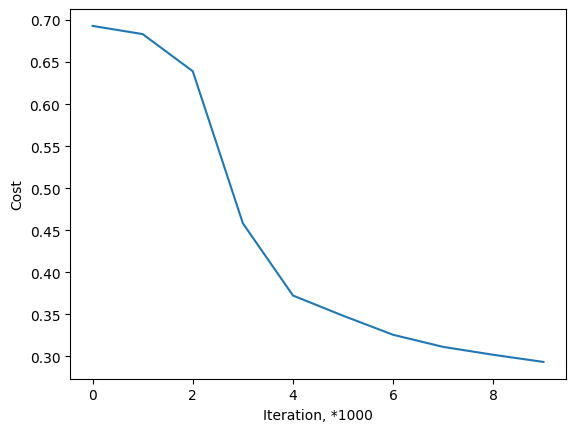

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
[[9 3]
 [3 9]]


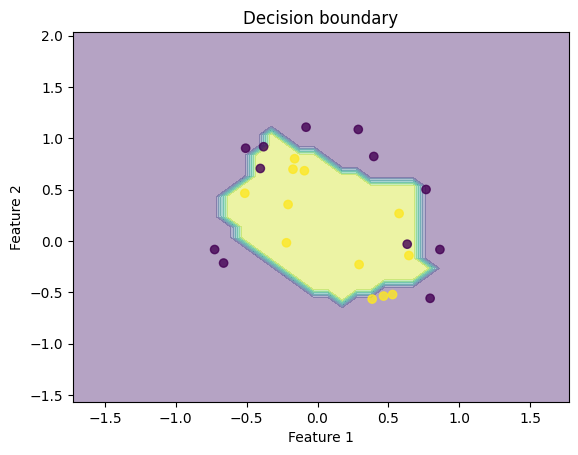

In [43]:
nn = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 10000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [44]:
print(nn.parameters)

{'W1': array([[ 1.48626419e-01, -3.50326596e-02],
       [ 1.91793916e-01, -5.08588816e-02],
       [ 2.50802840e-01, -4.43805733e-02],
       [ 2.50396517e-01, -7.01175654e-02],
       [ 5.65541873e-01,  4.04713611e-02],
       [ 3.19147383e-01, -8.67890546e-02],
       [ 2.57707267e-01, -4.18042612e-02],
       [ 1.44682321e-01, -9.19959752e-05],
       [-1.90285161e-01,  2.66327055e+00],
       [-1.56092831e+00, -4.31538840e+00],
       [ 1.87121494e+00, -2.41556045e+00],
       [ 4.89348990e+00,  4.35875818e+00],
       [ 2.23021140e-01, -5.26119419e-02],
       [ 6.40576020e-01, -4.21530315e+00],
       [-7.98215602e-02,  1.33484285e+00],
       [-1.19637523e-01,  2.24518191e+00],
       [ 2.54456186e+00,  1.59083938e+00],
       [ 3.37541388e+00, -3.17182005e+00],
       [ 8.70426087e+00,  2.49872302e+00],
       [ 1.89863046e-01, -2.20593373e-02]]), 'b1': array([[-2.50763046e-02],
       [-5.21103225e-04],
       [-6.32342377e-03],
       [ 1.57236730e-03],
       [ 2.66198150e-

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
[[10  2]
 [ 3  9]]


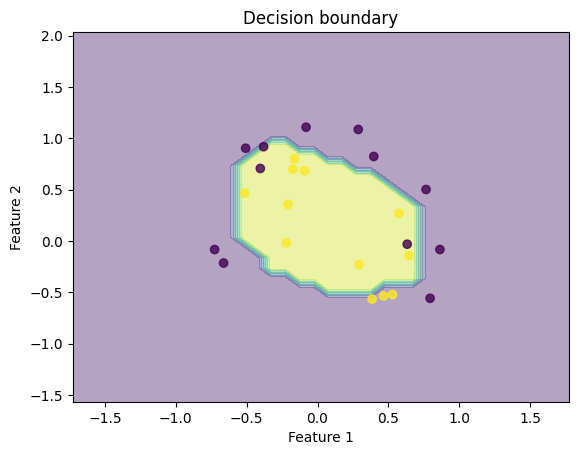

In [45]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [46]:
clf.n_iter_

1809